### 모듈 import

In [24]:
import os
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

### 파일 불러오기

In [26]:
CSV_BASE_PATH = r"C:\Users\selfi\Desktop\olist\csv"

file_paths = {
    "customers": os.path.join(CSV_BASE_PATH, "olist_customers_dataset.csv"),
    "orders": os.path.join(CSV_BASE_PATH, "olist_orders_dataset.csv"),
    "order_items": os.path.join(CSV_BASE_PATH, "olist_order_items_dataset.csv"),
    "reviews": os.path.join(CSV_BASE_PATH, "olist_order_reviews_dataset.csv"),
    "payments": os.path.join(CSV_BASE_PATH, "olist_order_payments_dataset.csv"),
    "products": os.path.join(CSV_BASE_PATH, "olist_products_dataset.csv"),
    "categories": os.path.join(CSV_BASE_PATH, "product_category_name_translation.csv"),
    "geolocation": os.path.join(CSV_BASE_PATH, "olist_geolocation_dataset.csv"),
}

customers   = pd.read_csv(file_paths["customers"])
orders     = pd.read_csv(file_paths["orders"])
order_items = pd.read_csv(file_paths["order_items"])
reviews     = pd.read_csv(file_paths["reviews"])
payments    = pd.read_csv(file_paths["payments"])
products    = pd.read_csv(file_paths["products"])
categories  = pd.read_csv(file_paths["categories"])
geolocation = pd.read_csv(file_paths["geolocation"])

print("Loaded shapes:",
      customers.shape, orders.shape, order_items.shape, reviews.shape,
      payments.shape, products.shape, categories.shape, geolocation.shape)

Loaded shapes: (99441, 5) (99441, 8) (112650, 7) (99224, 7) (103886, 5) (32951, 9) (71, 2) (1000163, 5)


### 결제수단 별 approve 처리 시간

In [37]:
orders_eda_1 = orders[['order_id', 'order_purchase_timestamp', 'order_approved_at']].copy()
orders_eda_1['order_purchase_timestamp'] = pd.to_datetime(orders_eda_1['order_purchase_timestamp'], errors='coerce')
orders_eda_1['order_approved_at'] = pd.to_datetime(orders_eda_1['order_approved_at'], errors='coerce')

orders_eda_1['approve_hours'] = (orders_eda_1['order_approved_at'] - orders_eda_1['order_purchase_timestamp']).dt.total_seconds() / 3600
orders_eda_1 = orders_eda_1.dropna(subset=['approve_hours'])

op = orders_eda_1.merge(
    payments[['order_id', 'payment_type']],
    on='order_id',
    how='inner'
)

op = op.drop_duplicates(subset=['order_id', 'payment_type'])

summary = (
    op.groupby('payment_type')['approve_hours']
      .agg(
          n='count',
          mean='mean',
          median='median',
          max='max'
      )
      .sort_values('median', ascending=False)
      .round(2)
)

summary

,n,mean,median,max
payment_type,,,,
boleto,19754,33.12,29.07,1450.87
debit_card,1528,9.55,0.85,676.07
voucher,3793,7.42,0.28,285.31
credit_card,76449,4.59,0.27,4509.18


In [38]:
iqr_tbl = (
    op.groupby('payment_type')['approve_hours']
      .quantile([0.25, 0.75])
      .unstack()
      .rename(columns={0.25: 'q1', 0.75: 'q3'})
      .reset_index()
)

iqr_tbl['iqr'] = iqr_tbl['q3'] - iqr_tbl['q1']
iqr_tbl['lower_fence'] = iqr_tbl['q1'] - 1.5 * iqr_tbl['iqr']
iqr_tbl['upper_fence'] = iqr_tbl['q3'] + 1.5 * iqr_tbl['iqr']

op_iqr = op.merge(
    iqr_tbl[['payment_type', 'lower_fence', 'upper_fence']],
    on='payment_type',
    how='left'
)

op_iqr = op_iqr[
    (op_iqr['approve_hours'] >= op_iqr['lower_fence']) &
    (op_iqr['approve_hours'] <= op_iqr['upper_fence'])
].copy()

summary_before = (
    op.groupby('payment_type')['approve_hours']
      .agg(n='count', mean='mean', median='median', max='max')
      .sort_values('median', ascending=False)
      .round(2)
)

summary_after = (
    op_iqr.groupby('payment_type')['approve_hours']
          .agg(n='count', mean='mean', median='median', max='max')
          .sort_values('median', ascending=False)
          .round(2)
)

trim_rate = (
    summary_before[['n']]
      .rename(columns={'n': 'n_before'})
      .join(summary_after[['n']].rename(columns={'n': 'n_after'}), how='left')
      .fillna({'n_after': 0})
)
trim_rate['trim_rate'] = (1 - trim_rate['n_after'] / trim_rate['n_before']).round(4)

summary_before
summary_after
trim_rate


,n_before,n_after,trim_rate
payment_type,,,
boleto,19754,18165,0.0804
debit_card,1528,1322,0.1348
voucher,3793,2950,0.2223
credit_card,76449,62547,0.1818


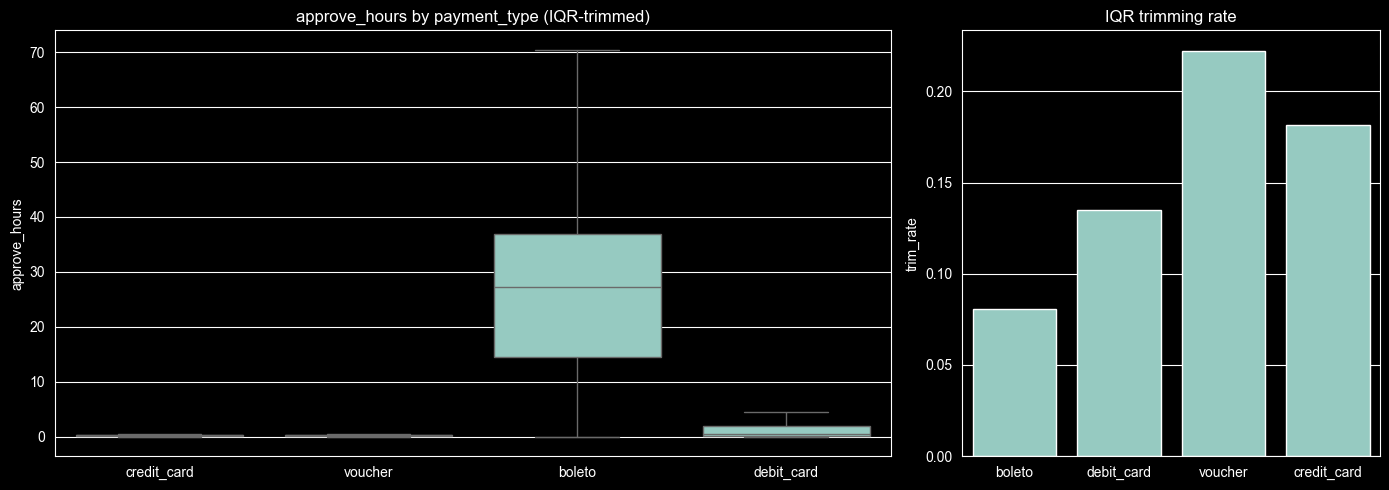

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), gridspec_kw={'width_ratios': [2, 1]})

sns.boxplot(
    data=op_iqr,
    x='payment_type',
    y='approve_hours',
    showfliers=False,
    ax=axes[0]
)
axes[0].set_title('approve_hours by payment_type (IQR-trimmed)')
axes[0].set_xlabel('')
axes[0].set_ylabel('approve_hours')

plot_df = trim_rate.reset_index().rename(columns={'index': 'payment_type'})
sns.barplot(
    data=plot_df,
    x='payment_type',
    y='trim_rate',
    ax=axes[1]
)
axes[1].set_title('IQR trimming rate')
axes[1].set_xlabel('')
axes[1].set_ylabel('trim_rate')

plt.tight_layout()
plt.show()

### 카테고리 별 준비 시간

In [35]:
tmp = (
    order_items[['order_id','seller_id','product_id']]
    .merge(
        products[['product_id','product_category_name']]
          .merge(
              categories[['product_category_name','product_category_name_english']],
              on='product_category_name',
              how='left'
          ),
        on='product_id',
        how='left'
    )
    .merge(
        orders[['order_id','order_approved_at','order_delivered_carrier_date']],
        on='order_id',
        how='left'
    )
)

tmp['order_approved_at'] = pd.to_datetime(tmp['order_approved_at'], errors='coerce')
tmp['order_delivered_carrier_date'] = pd.to_datetime(tmp['order_delivered_carrier_date'], errors='coerce')

tmp['prep_days'] = (tmp['order_delivered_carrier_date'] - tmp['order_approved_at']).dt.total_seconds() / 86400

tmp['category_en'] = tmp['product_category_name_english'].fillna(tmp['product_category_name'])

tmp = tmp.dropna(subset=['prep_days', 'category_en', 'seller_id'])

cat_prep = (
    tmp.groupby('category_en')['prep_days']
       .agg(
           n='count',
           median='median',
           mean='mean',
           p95=lambda s: s.quantile(0.95),
           p99=lambda s: s.quantile(0.99)
       )
       .sort_values('median', ascending=False)
       .round(2)
)

cat_prep


,n,median,mean,p95,p99
category_en,,,,,
office_furniture,1678,9.93,10.27,20.49,27.56
fashion_shoes,259,4.15,5.22,13.32,21.40
diapers_and_hygiene,38,3.38,3.72,8.04,17.32
home_appliances_2,235,3.15,4.06,11.18,23.56
furniture_bedroom,105,3.09,4.07,12.77,17.35
...,...,...,...,...,...
fashion_childrens_clothes,7,0.94,1.41,3.28,3.76
security_and_services,2,0.91,0.91,1.13,1.15
books_imported,57,0.89,2.33,8.42,14.41
